In [1]:
#Gas-phase calculations

#Unit cell obtained from https://materialsproject.org/materials/mp-48/

import psi4

psi4.set_memory(4250000000)
psi4.set_num_threads(4)

molecule = psi4.geometry(""" 0 1
 C    0.000000    0.000000    2.171259
 C   -1.233862    2.137112    2.171259
 C    2.467724    0.000000    2.171259
 C    1.233862    2.137112    2.171259
 C    0.000000    0.000000    6.513778
 C   -1.233862    2.137112    6.513778
 C    2.467724    0.000000    6.513778
 C    1.233862    2.137112    6.513778
 C    1.233862    0.712371    2.171259
 C    0.000000    1.424741    6.513778
 C    0.000000   -1.424741    2.171259
 C   -1.233862    0.712371    2.171259
 C   -2.467724    2.849482    2.171259
 C    0.000000    2.849482    2.171259
 C    2.467724   -1.424741    2.171259
 C    3.701586    0.712371    2.171259
 C    2.467724    2.849482    2.171259
 C   -1.233862   -0.712371    6.513778
 C    1.233862   -0.712371    6.513778
 C   -2.467724    1.424741    6.513778
 C   -1.233862    3.561853    6.513778
 C    3.701586   -0.712371    6.513778
 C    2.467724    1.424741    6.513778
 C    1.233862    3.561853    6.513778
""", name= "ZnSe Primitive Cell")


psi4.set_options({
 "save_jk" : True,
})

e, wfn = psi4.energy("B3LYP/aug-cc-pVDZ", return_wfn=True, molecule=molecule)


  Memory set to   3.958 GiB by Python driver.
  Threads set to 4 by Python driver.

Scratch directory: /tmp/

*** tstart() called on Bedabratas-MacBook-Air.local
*** at Sat Jul  9 17:42:01 2022

   => Loading Basis Set <=

    Name: AUG-CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-24 entry C          line   182 file /opt/miniconda3/share/psi4/basis/aug-cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RKS Reference
                        4 Threads,   4053 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C1

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    -----

   @DF-RKS iter  13:  -912.64828543390229   -6.19230e-06   1.97566e-06 DIIS
   @DF-RKS iter  14:  -912.64828595405129   -5.20149e-07   1.51073e-06 DIIS
   @DF-RKS iter  15:  -912.64828615650174   -2.02450e-07   1.28609e-06 DIIS
   @DF-RKS iter  16:  -912.64828657682767   -4.20326e-07   4.60014e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =  143.9993947386 ; deviation = -6.053e-04 

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A    -10.381279     2A    -10.381273     3A    -10.347757  
       4A    -10.347754     5A    -10.347745     6A    -10.347741  
       7A    -10.338714     8A    -10.338703     9A    -10.338701  
      10A    -10.338690    11A    -10.328063    12A    -10.328058  
      13A    -10.296480    14A    -10.296465    15A    -10.296457  
      16A    -10.296442    17A    -10.287618    18A    -10.287601  


*** tstop() called on Bedabratas-MacBook-Air.local at Sat Jul  9 18:05:32 2022
Module time:
	user time   =    2429.49 seconds =      40.49 minutes
	system time =     621.33 seconds =      10.36 minutes
	total time  =       1411 seconds =      23.52 minutes
Total time:
	user time   =    2429.49 seconds =      40.49 minutes
	system time =     621.33 seconds =      10.36 minutes
	total time  =       1411 seconds =      23.52 minutes


In [2]:
HOMO = wfn.epsilon_a_subset('AO', 'ALL').np[wfn.nalpha()]
LUMO = wfn.epsilon_a_subset('AO', 'ALL').np[wfn.nalpha() + 1]
print(HOMO, LUMO, e)

-0.21351993293578417 -0.21248661520792242 -912.6482865768277


In [3]:
band_gap=(LUMO-HOMO)*27.2114 

print(band_gap)

0.028118022019937197


In [5]:
#Estimate nanoparticle volume and calculate radius of nanoparticle assuming it's enclosed in a sphere

import deepchem
import numpy as np

#from https://github.com/deepchem/deepchem/blob/master/deepchem/utils/rdkit_utils.py

import os
import logging
import itertools
import numpy as np
from io import StringIO
from deepchem.utils.pdbqt_utils import pdbqt_to_pdb
from deepchem.utils.pdbqt_utils import convert_mol_to_pdbqt
from deepchem.utils.pdbqt_utils import convert_protein_to_pdbqt
from deepchem.utils.geometry_utils import compute_pairwise_distances
from deepchem.utils.geometry_utils import compute_centroid
from deepchem.utils.fragment_utils import MolecularFragment
from deepchem.utils.fragment_utils import MoleculeLoadException
from typing import Any, List, Tuple, Set, Optional, Dict
from deepchem.utils.typing import OneOrMany, RDKitMol

logger = logging.getLogger(__name__)


def get_xyz_from_mol(mol):
  """Extracts a numpy array of coordinates from a molecules.
  Returns a `(N, 3)` numpy array of 3d coords of given rdkit molecule
  Parameters
  ----------
  mol: rdkit Molecule
    Molecule to extract coordinates for
  Returns
  -------
  Numpy ndarray of shape `(N, 3)` where `N = mol.GetNumAtoms()`.
  """
  xyz = np.zeros((mol.GetNumAtoms(), 3))
  conf = mol.GetConformer()
  for i in range(conf.GetNumAtoms()):
    position = conf.GetAtomPosition(i)
    xyz[i, 0] = position.x
    xyz[i, 1] = position.y
    xyz[i, 2] = position.z
  return (xyz)

import rdkit
from rdkit import Chem


#Crystal imported from Avogadro software and converted to mol file with OpenBabel

m= Chem.MolFromMolFile('graphene.mol')

coords= get_xyz_from_mol(m)

from scipy.spatial import ConvexHull

hull = ConvexHull(coords)


cell_volume = hull.volume #This is in cubic Angstroms
radius_0=(3/4*(cell_volume/np.pi))**(1/3)

In [6]:
radius_0

2.7165472617897435

Text(0, 0.5, 'Band-Gap(eV)')

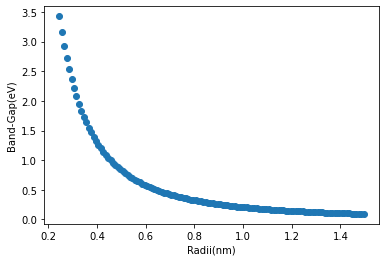

In [122]:
# From the paper Electron-electron and electron-hole interactions in small semiconductor crystallites : The size dependence of the lowest excited electronic state
#Bamd gap/HOMO-LUMO gap varies as 1/R^2 with the nanoparticle radius

#http://fizyka.umk.pl/~wj/EDU/Pracownia_Projektowa/brus.pdf


def gap_as_a_function_of_radius(R):
    
    res=((band_gap)*(radius_0)**2)/(R**2)      #converting gap to electron volts
    return res


import matplotlib.pyplot as plt

radii=np.arange(0.246,1.5,.01)     #graphene unit cell is 0.246 nm
gaps=[gap_as_a_function_of_radius(R) for R in radii]
plt.scatter(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Band-Gap(eV)")

In [93]:
gap_as_a_function_of_radius(0.5) #compare with http://what-when-how.com/nanoscience-and-nanotechnology/carbon-nanotubes-and-other-carbon-materials-part-1-nanotechnology/

0.8300022857561079

In [94]:
#Load Hydration Free Energy Model
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import sklearn
import joblib

loaded_model = joblib.load('dielectric_new.sav')

In [95]:
def dielectric_constant_solute(R):
    return loaded_model.predict(np.array([gap_as_a_function_of_radius(R)]).reshape(-1,1))[0]

In [102]:
dielectric_constant_solute(0.5)

17.43636821428571

Text(0, 0.5, 'Dielectric Constant')

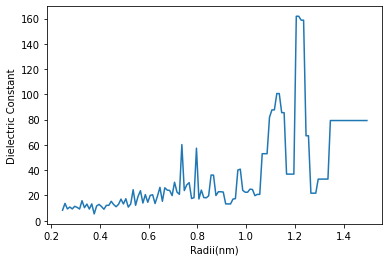

In [124]:
radii=np.arange(0.246,1.5,.01)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[dielectric_constant_solute(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Dielectric Constant")

In [100]:
#Calculate ground-state exciton energy as a function of nanoparticle radii

def exciton_energy(R):
    coulomb_interaction=(1.8*1.60217663/(R*(dielectric_constant_solute(R))))                
    coul_ev=(coulomb_interaction)
    res=gap_as_a_function_of_radius(R)-coul_ev
    return res

In [104]:
exciton_energy(0.5)

0.49920886609923343

Text(0, 0.5, 'Exciton Energies(eV)')

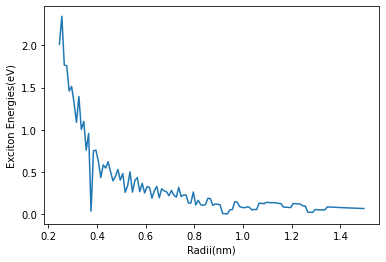

In [105]:
import matplotlib.pyplot as plt

radii=np.arange(0.246,1.5,.01)     
gaps=[exciton_energy(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Exciton Energies(eV)")

Text(0, 0.5, 'gap-exciton differences(eV)')

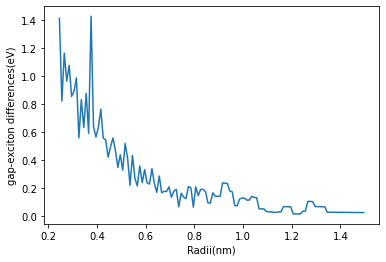

In [107]:
import matplotlib.pyplot as plt

radii=np.arange(0.246,1.5,0.01)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[gap_as_a_function_of_radius(R)-exciton_energy(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("gap-exciton differences(eV)")

In [74]:
from rdkit import Chem
from pygamess import Gamess
from pygamess.utils import rdkit_optimize
m= Chem.MolFromMolFile("graphene.mol")
g = Gamess(num_cores=1)
g.pcm_type("water")
r = g.run(m)

In [108]:
from pygamess import Gamess
from pygamess.utils import rdkit_optimize
m = Chem.MolFromMolFile("graphene.mol")
g = Gamess()
r2 = g.run(m)

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


In [115]:
fraction_gas_phase=band_gap/((r2.LUMO-r2.HOMO)*27.2114)
band_gap_solvated=fraction_gas_phase*((r.LUMO-r.HOMO)*27.2114)

In [116]:
fraction_gas_phase

0.35631645788336175

In [111]:
def gap_as_a_function_of_radius_solvated(R):
    
    res=((band_gap_solvated)*(radius_0)**2)/(R**2)      #converting gap to electron volts
    return res

In [113]:
gap_as_a_function_of_radius_solvated(0.5)

6.153465221984939

Text(0, 0.5, 'Band-Gap(eV)')

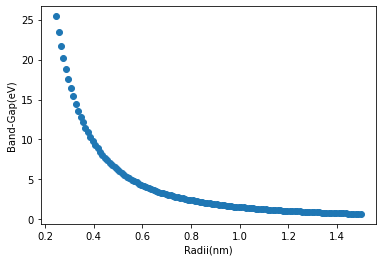

In [125]:
import matplotlib.pyplot as plt

radii=np.arange(0.246,1.5,.01)     
gaps=[gap_as_a_function_of_radius_solvated(R) for R in radii]
plt.scatter(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Band-Gap(eV)")

In [117]:
#Calculate ground-state exciton energy as a function of nanoparticle radii

def exciton_energy_solvated(R):
    coulomb_interaction=(1.8*1.60217663/(R*(dielectric_constant_solute(R))))                
    coul_ev=(coulomb_interaction)
    res=gap_as_a_function_of_radius_solvated(R)-coul_ev
    return res

In [119]:
exciton_energy_solvated(0.5)

5.822671802328064

Text(0, 0.5, 'Exciton Energies_Solvated-Exciton_energies_gas_phase(eV)')

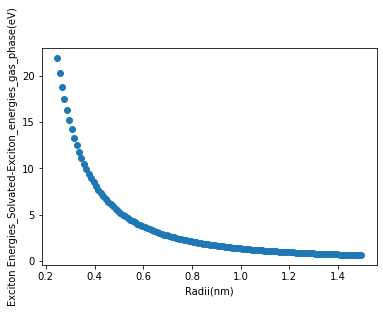

In [126]:
import matplotlib.pyplot as plt

radii=np.arange(0.246,1.5,.01)     
gaps=[exciton_energy_solvated(R)-exciton_energy(R) for R in radii]
plt.scatter(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Exciton Energies_Solvated-Exciton_energies_gas_phase(eV)")